<div class="alert alert-block alert-info"> <b>NOTE:</b> This jupyter notebook is a companion to the <b>comparing_annotations.md</b> file. For more details read that documentation first and then come back here. </div>   
   
# Vs. reference performance gffcompare
The code for the comparison uses a lot of files that won't be uploaded here. This is simply an **example** and a **documentation** of how to plot gene annotations from different sources/gene callers compared with the reference using gffcompare. This notebook just includes examples from plant species used for evaluation of Helixer and the final summary plot for all lineages. The plots are shown in a low resolution to keep the notebook file size smaller.  
   
The expected file structure the code is working with is as follows:

Each species folder is structured as follows (only files important for the analysis are mentioned):

## Parsing the data
Now that we know how the directories we will be using are structured, we can start with parsing the gffcompare output file `gffcompare.stats` for every gene caller, Helixer, AUGUSTUS and GeneMark.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

import seaborn as sns
import re

Example gffcompare statistics (gffcompare doesn't compare base-wise statistics, but for example if the whole intron was predicted in the exact same position as the reference intron):

In [2]:
path = '../summary/plant/Arachis_hypogaea/gffcompare/helixer_post/gffcompare.stats'
with open(path, 'r') as f:
    for line in f.readlines():
        print(line, end='')

# gffcompare v0.12.8 | Command line was:
#gffcompare -r tmp_gffcompare_cleaner/reference.gff3 -o ../summary/plant/Arachis_hypogaea/gffcompare/helixer_post/gffcompare tmp_gffcompare_cleaner/alternate.gff3
#

#= Summary for dataset: tmp_gffcompare_cleaner/alternate.gff3 
#     Query mRNAs :   71637 in   71637 loci  (56621 multi-exon transcripts)
#            (0 multi-transcript loci, ~1.0 transcripts per locus)
# Reference mRNAs :   65874 in   65841 loci  (51712 multi-exon)
# Super-loci w/ reference transcripts:    51646
#-----------------| Sensitivity | Precision  |
        Base level:    82.3     |    83.5    |
        Exon level:    81.3     |    70.3    |
      Intron level:    83.4     |    71.0    |
Intron chain level:    51.0     |    46.5    |
  Transcript level:    53.4     |    49.1    |
       Locus level:    53.5     |    49.1    |

     Matching intron chains:   26351
       Matching transcripts:   35209
              Matching loci:   35208

          Missed exons:   40957/3

Example pandas dataframe created from the gffcompare statistics:

In [3]:
def read_gffcompare(filename):
    lines = []
    with open(filename, 'r') as f:
        for line in f:
            if line.find('level') > -1:  # if the line contains the word 'level'
                line = line.rstrip()
                line = re.split(':|\|', line)  # split line by ':' and '|'
                line = [x.strip() for x in line][:-1]  # there was a trailing |, which :-1 removes
                line[0] = re.sub(' level', '', line[0])  # remove 'level', i.e. Exon level -> Exon
                lines.append(line)
    if not lines: # empty file
        return None
    dat = pd.DataFrame(lines)
    dat.columns = ['level', 'recall', 'precision']
    return dat

In [4]:
read_gffcompare(path)

,level,recall,precision
0,Base,82.3,83.5
1,Exon,81.3,70.3
2,Intron,83.4,71.0
3,Intron chain,51.0,46.5
4,Transcript,53.4,49.1
5,Locus,53.5,49.1


We import the `gffcompare.stats` file from every lineage (i.e. plant, fungi, vertebrate or invertebrate), species and available tool (i.e. helixer_post, genemark, augustus) in the given base directory.

In [5]:
def import_full_species(basedir):
    vs_ref_dfs = {}
    for phylo_group in os.listdir(basedir):
        vs_ref_dfs[phylo_group] = {}
        try:
            for species in os.listdir(os.path.join(basedir, phylo_group)):
                vs_ref_dfs[phylo_group][species] = {}
                for tool in os.listdir(os.path.join(basedir, phylo_group, species, 'gffcompare')):
                    dat = read_gffcompare(os.path.join(basedir, phylo_group, species, 'gffcompare', 
                                                       tool, 'gffcompare.stats'))
                    if dat is not None:
                        dat['tool'] = tool
                        dat['group'] = phylo_group
                        dat['species'] = species
                        vs_ref_dfs[phylo_group][species][tool] = dat
        except ValueError as e:  # this should only come up wile import is still running...
            raise e
    return vs_ref_dfs

In [6]:
# nested directories
full_data = import_full_species('../summary/')

In [7]:
def flatten_all(df_dict):
    lists = []
    for phylo_group_dict in df_dict.values():
        for species_dict in phylo_group_dict.values():
            for dat in species_dict.values():
                lists.append(dat)
    df = pd.concat(lists)
    return df

In [8]:
full_df = flatten_all(full_data)
full_df

,level,recall,precision,tool,group,species
0,Base,89.6,84.0,helixer_post,invertebrate,Trachymyrmex_cornetzi
1,Exon,79.6,65.5,helixer_post,invertebrate,Trachymyrmex_cornetzi
2,Intron,78.8,65.9,helixer_post,invertebrate,Trachymyrmex_cornetzi
3,Intron chain,32.2,25.2,helixer_post,invertebrate,Trachymyrmex_cornetzi
4,Transcript,32.6,24.5,helixer_post,invertebrate,Trachymyrmex_cornetzi
...,...,...,...,...,...,...
1,Exon,0.0,0.0,genemark,vertebrate,Chiroxiphia_lanceolata
2,Intron,0.0,0.0,genemark,vertebrate,Chiroxiphia_lanceolata
3,Intron chain,0.0,0.0,genemark,vertebrate,Chiroxiphia_lanceolata
4,Transcript,0.0,0.0,genemark,vertebrate,Chiroxiphia_lanceolata


In [9]:
def adapt_metrics(df):
    df['recall'] = [float(x) / 100 for x in df['recall']]
    df['precision'] = [float(x) / 100 for x in df['precision']]
    df['F1'] = 2 / (1 / df['recall'] + 1 / df['precision'])
    return df

In [10]:
full_df = adapt_metrics(full_df)
full_df

,level,recall,precision,tool,group,species,F1
0,Base,0.896,0.840,helixer_post,invertebrate,Trachymyrmex_cornetzi,0.867097
1,Exon,0.796,0.655,helixer_post,invertebrate,Trachymyrmex_cornetzi,0.718649
2,Intron,0.788,0.659,helixer_post,invertebrate,Trachymyrmex_cornetzi,0.717750
3,Intron chain,0.322,0.252,helixer_post,invertebrate,Trachymyrmex_cornetzi,0.282732
4,Transcript,0.326,0.245,helixer_post,invertebrate,Trachymyrmex_cornetzi,0.279755
...,...,...,...,...,...,...,...
1,Exon,0.000,0.000,genemark,vertebrate,Chiroxiphia_lanceolata,0.000000
2,Intron,0.000,0.000,genemark,vertebrate,Chiroxiphia_lanceolata,0.000000
3,Intron chain,0.000,0.000,genemark,vertebrate,Chiroxiphia_lanceolata,0.000000
4,Transcript,0.000,0.000,genemark,vertebrate,Chiroxiphia_lanceolata,0.000000


We now devide all metrics by the level, we want exon, intron, intron chain and transcript level statistics. Afterwards we sort the dataframes, so the order is identical to the BUSCO plots.

In [11]:
def split_by_level(df, targets):
    subdfs = [df[df['level'] == target] for target in targets]
    
    dfs = []
    for df in subdfs:
        # index by species and group
        # switch tools to column names
        # only values in the dataframe now: precision, recall, F1
        df = pd.pivot(df.iloc[:, [1, 2, 3, 4, 5, 6]], 
                      index=['species', 'group'], columns='tool',
                      values=['precision', 'recall', 'F1'])
        df = df.reset_index('group')
        df = df.sort_values('group')
        dfs.append(df)

    return dfs

In [12]:
exon_df, intron_df, intron_chain_df, transcript_df = split_by_level(full_df, ['Exon', 'Intron', 'Intron chain', 'Transcript'])

In [13]:
# summary statistics for exons
exon_df.describe().iloc[[1, 2], :].round(4)

precision                         recall                             F1  \
tool  augustus genemark helixer_post augustus genemark helixer_post augustus   
mean    0.5977   0.2969       0.6371   0.6053   0.4508       0.7832   0.5919   
std     0.1487   0.2785       0.1405   0.0739   0.3072       0.1401   0.1029   

                            
tool genemark helixer_post  
mean   0.3376       0.6967  
std    0.2805       0.1371

In [14]:
busco_ref_sort = ['Neurospora_crassa', 'Coccidioides_immitis', 'Fusarium_graminearum',
       'Debaryomyces_hansenii', 'Aspergillus_terreus', 'Laccaria_bicolor',
       'Papaver_somniferum', 'Arachis_hypogaea', 'Brassica_napus',
       'Oryza_brachyantha', 'Nicotiana_attenuata', 'Solanum_pennellii',
       'Setaria_viridis', 'Vitis_riparia', 'Triticum_dicoccoides',
       'Phoenix_dactylifera', 'Coffea_arabica', 'Cannabis_sativa',
       'Hibiscus_syriacus', 'Balaenoptera_musculus', 'Xiphias_gladius',
       'Sparus_aurata', 'Desmodus_rotundus', 'Pseudonaja_textilis',
       'Falco_naumanni', 'Chiroxiphia_lanceolata', 'Myotis_davidii',
       'Lagopus_leucura', 'Rhincodon_typus', 'Opisthocomus_hoazin',
       'Bombus_impatiens', 'Tribolium_castaneum', 'Drosophila_virilis',
       'Apis_dorsata', 'Frankliniella_occidentalis', 'Trachymyrmex_cornetzi',
       'Drosophila_albomicans', 'Ctenocephalides_felis', 'Atta_cephalotes',
       'Rhopalosiphum_maidis', 'Culex_pipiens', 'Hyposmocoma_kahamanoa',
       'Caenorhabditis_remanei', 'Schistosoma_mansoni',
       'Opisthorchis_viverrini']

In [15]:
# first three entries in exon dataframe
exon_df.iloc[:3,:]

group precision                         recall           \
tool                        augustus genemark helixer_post augustus genemark   
species                                                                        
Aspergillus_terreus  fungi     0.653    0.656        0.538    0.659    0.679   
Neurospora_crassa    fungi     0.756    0.854        0.799    0.634    0.783   
Laccaria_bicolor     fungi     0.549    0.529        0.397    0.503    0.523   

                                        F1                         
tool                helixer_post  augustus  genemark helixer_post  
species                                                            
Aspergillus_terreus        0.623  0.655986  0.667302     0.577388  
Neurospora_crassa          0.811  0.689646  0.816960     0.804955  
Laccaria_bicolor           0.482  0.524994  0.525983     0.435390

In [16]:
def reorder_df(df, sort_order):
    # reorder columns, so they are the same as the BUSCO plots/tables
    first = list(df.columns)[0]  # group column
    cols = [(metric, tool) for metric in ['precision', 'recall', 'F1'] for tool in ['helixer_post', 'genemark', 'augustus']]
    df = df[[first] + cols]

    # rename
    df = df.rename({'helixer_post': 'helixer post'}, axis=1)

    # sort according to sort order
    df = df.loc[sort_order, :]
    return df

In [17]:
exon_df, intron_df, intron_chain_df, transcript_df = [reorder_df(df, busco_ref_sort)
                                                      for df in [exon_df, intron_df, intron_chain_df, transcript_df]]

In [18]:
# first three entries in the reordered exon dataframe
exon_df.iloc[:3,:]

group    precision                         recall  \
tool                        helixer post genemark augustus helixer post   
species                                                                   
Neurospora_crassa     fungi        0.799    0.854    0.756        0.811   
Coccidioides_immitis  fungi        0.771    0.853    0.754        0.720   
Fusarium_graminearum  fungi        0.608    0.747    0.732        0.605   

                                                 F1                      
tool                 genemark augustus helixer post  genemark  augustus  
species                                                                  
Neurospora_crassa       0.783    0.634     0.804955  0.816960  0.689646  
Coccidioides_immitis    0.708    0.626     0.744628  0.773766  0.684064  
Fusarium_graminearum    0.683    0.635     0.606496  0.713568  0.680059

## Plots
Now, we plot the F1 scores for every dataframe.

In [19]:
def plot_f1_summary(df_reorder, figsize=(2.5,4.5), dpi=100, ylab="F1", fsize=10, figname='filler'):
    # set colors
    cmap=plt.get_cmap("Set1")
    x = [8, 1, 0, 2]  # 2=green, 8=grey, 0=red, 1=blue
    colors = np.array(cmap.colors)[np.array(x)]
    
    # order colors to match 
    key={'invertebrate': 0, 'vertebrate': 2, 'fungi': 1, 'plant': 3}
    newc = [colors[key[x]] for x in df_reorder['group']]
    
    # main plot
    # -----------
    sns.set_theme(rc={'figure.dpi': dpi})
    sns.set_style("dark")  # options: white, dark, whitegrid, darkgrid, ticks (heatmap background/missing data values)
    cg = sns.clustermap(df_reorder.iloc[:,1:], cmap='viridis', vmin=0, vmax=1,
                        cbar_kws={'label': ylab, 'fraction': 0.07},
                        row_cluster=False, yticklabels=False, col_cluster=False, row_colors=newc,
                        figsize=figsize, cbar_pos=(1, 0.35, 0.1, 0.3), 
                        colors_ratio=0.07)
    
    ylabs, start, lengths = np.unique(df_reorder['group'], return_counts=True, return_index=True)
    
    cg.ax_row_colors.set_yticks(start + lengths // 2)
    cg.ax_row_colors.set_yticklabels(ylabs, rotation=60, size=fsize)
    cg.ax_heatmap.set_xticklabels([method[1] for i, method in enumerate(df_reorder.columns) if i != 0], fontsize = fsize)
    cg.ax_heatmap.set_xlabel('')
    
    # save figure
    #cg.savefig(f"joint/{figname}.pdf")
    #cg.savefig(f"joint/{figname}.eps")

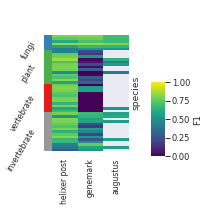

In [20]:
plot_f1_summary(exon_df.iloc[:,[0,7,8,9]], dpi=55)

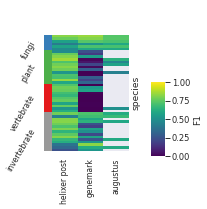

In [21]:
plot_f1_summary(intron_df.iloc[:,[0,7,8,9]], dpi=55)

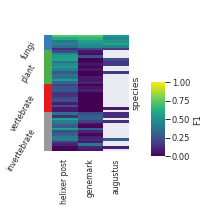

In [22]:
plot_f1_summary(intron_chain_df.iloc[:,[0,7,8,9]], dpi=55)

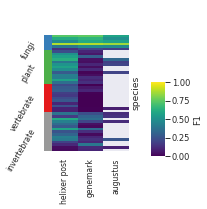

In [23]:
plot_f1_summary(transcript_df.iloc[:,[0,7,8,9]], dpi=55)

## Tables
Lastly, we will export the dataframes to tables.

In [24]:
for df, name in zip([exon_df, intron_df, intron_chain_df, transcript_df],['exon', 'intron', 'intron_chain', 'transcript']):
    df.to_csv(f'joint/gffcompare_{name}.csv')
    df.to_latex(f'joint/gffcompare_{name}.tex')